<a href="https://colab.research.google.com/github/sromanov103/clothing_creation/blob/main/clothing_creation_%D0%94%D0%B7_35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D , MaxPooling2D
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape, ReLU
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
ds = tf.keras.datasets.fashion_mnist
(train_images, _), (test_images, _) = ds.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
SIZE = 28                  # линейный размер изображений (одно измерение)
INPUT_IMG = (SIZE, SIZE, 1) # размер входного изображений
BATCH_SIZE = 64             # размер пакета для обучения
LATENT_DIM = 100            # размерность латентного пространства

In [ ]:
train_images = train_images.reshape(train_images.shape[0], *INPUT_IMG).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [ ]:
train_images.shape

(60000, 28, 28, 1)

In [ ]:
print("Форма train_images:", train_images.shape)
print("Тип данных train_images:", train_images.dtype)

Форма train_images: (60000, 28, 28, 1)
Тип данных train_images: float32


In [ ]:
print(list(train_images[:1]))

[array([[[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        

In [ ]:
print(len(train_images))

60000


In [ ]:
dataset=tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)

In [ ]:
print(len(dataset))

938


<ipython-input-12-88fcde880353>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(sqr,sqr,i+1)


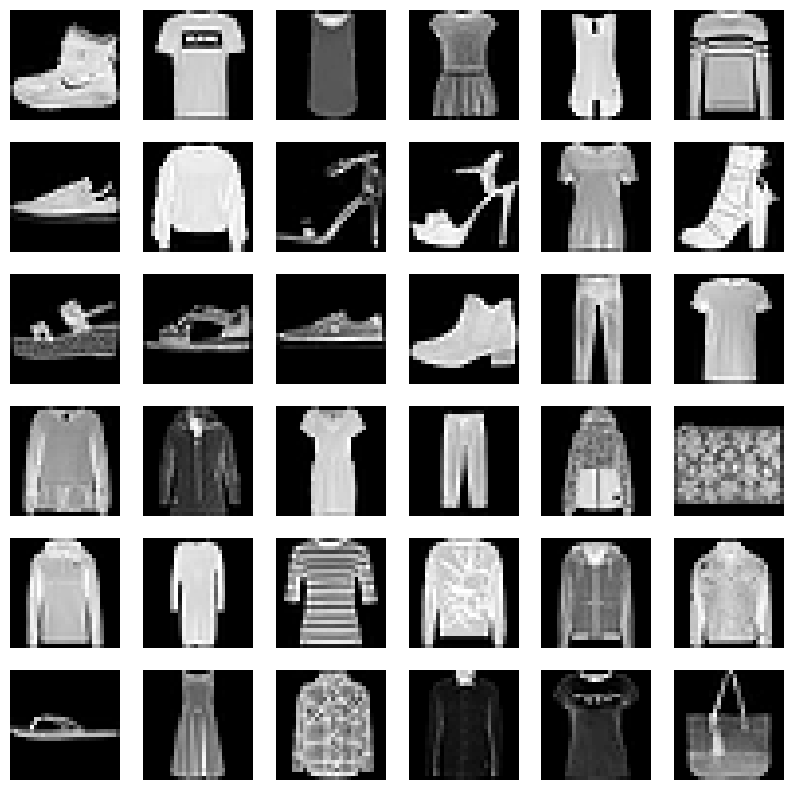

In [ ]:
import matplotlib.pyplot as plt

def plot_images(images, sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Реальные изображения", fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(images[i], cmap='gray' )
        plt.axis('off')

# to plot images
plot_images(train_images, 6)

In [ ]:
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    return fake_loss + real_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# Мы используем декоратор `tf.function`, можно и без него
# Он указывает на то, что функция должна быть скомпилирована, что оптимизирует процесс обучения.
# @tf.function
def train_steps(images, generator, discriminator):

    # генерируем шум на входе генератора
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))

    # Инициализируем GradientTape (градиентную ленту) для дискриминатора и генератор
    #  по отдельности, чтобы записать операции,
    # выполняемые во время прямого прохода, включающего автодифференцирование.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Запустим прямой проход шума через генератор.
        # Операции применяемые каждым слоем к своим
        # входным данным будут записаны на GradientTape, как на ленту магнитофона.
        # Отсюда и название градиентной ленты.
        generated_images = generator(noise)

        # Также обеспечиваем прямой проход через дискриминатор для
        # для реальных и фейковых изображений
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)

        # расчитываем функции ошибок (значения потерь)
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)

    # Используем gradient tape для автоматического извлечения градиентов
    # обучаемых переменных относительно потерь.
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)

    # Выполним один шаг градиентного спуска, обновив
    # значение переменных минимизирующих потери.
    optimizer_G.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer_D.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

    # Вернем значения потерь для визуализации
    loss = {'gen_loss':gen_loss,
           'disc_loss': dis_loss}
    return loss

In [ ]:
import time
def train(epochs, dataset, generator, discriminator):
    D_loss=[] # список для сбора значений потерь для дискриминатора
    G_loss=[] # список для сбора значений потерь для генератора
    for epoch in range(epochs):
        start = time.time()
        print("\nЭпоха : {}".format(epoch + 1))
        for images in dataset:

            loss = train_steps(images, generator, discriminator)
        print(" Время:{}".format(np.round(time.time() - start),2))
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen_loss'],loss['disc_loss']))
        D_loss.append(loss['disc_loss'])
        G_loss.append(loss['gen_loss'])
    return (G_loss, D_loss)

#Архитектура сети

Генератор

In [ ]:
from tensorflow.keras import layers
def Generator():
    model = Sequential()

    model.add(Dense(7*7*128, input_shape=[LATENT_DIM]))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Reshape для перехода в формат изображения
    model.add(Reshape((7,7, 128)))

    # model.add(Conv2DTranspose(128, 5, strides=(2,2), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(ReLU())

    model.add(Conv2DTranspose(64, 5, strides=(2,2),  padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(1, 5,strides=(2,2), padding='same', activation='tanh'))

    return model

In [ ]:
from keras.models import Sequential
generator = Generator()
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6272)                │         633,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 6272)                │          25,088 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 865,281 (3.30 MB)

 Trainable params: 852,609 (3.25 MB)

 Non-trainable params: 12,672 (49.50 KB)

Дискриминатор


In [ ]:
def Discriminator():
    model = tf.keras.Sequential()


    model.add(Conv2D(64, 4, strides=2, padding='same', input_shape=INPUT_IMG))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, 3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation = 'sigmoid'))

    return model

In [ ]:
discriminator = Discriminator()
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,985 (320.25 KB)

 Trainable params: 81,601 (318.75 KB)

 Non-trainable params: 384 (1.50 KB)

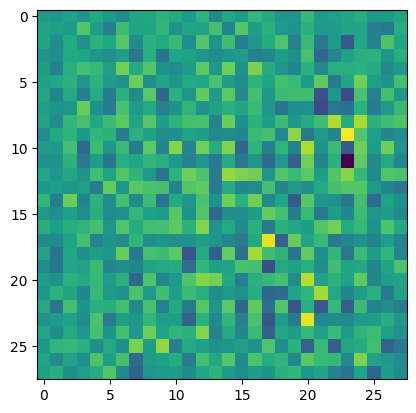

In [ ]:
noise = np.random.normal(-1,1,(1,LATENT_DIM))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

Определение функции потерть оптимизатора

In [ ]:
optimizer_G = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_D = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5)

# Этот метод возвращает вспомогательную функцию для вычисления перекрестных потерь энтропии
cross_entropy = tf.keras.losses.BinaryCrossentropy()

#Обучение

In [ ]:
G, D = train(20, dataset, generator, discriminator )


Эпоха : 1
 Время:202.0
Generator Loss: 1.0595777034759521 Discriminator Loss: 0.9644155502319336

Эпоха : 2
 Время:202.0
Generator Loss: 1.3977687358856201 Discriminator Loss: 0.8463096022605896

Эпоха : 3
 Время:150.0
Generator Loss: 1.1432570219039917 Discriminator Loss: 0.9162074327468872

Эпоха : 4
 Время:202.0
Generator Loss: 1.0662150382995605 Discriminator Loss: 1.0800806283950806

Эпоха : 5
 Время:150.0
Generator Loss: 0.9733825922012329 Discriminator Loss: 1.0762523412704468

Эпоха : 6
 Время:150.0
Generator Loss: 0.6963182091712952 Discriminator Loss: 1.320066213607788

Эпоха : 7
 Время:202.0
Generator Loss: 0.8356531858444214 Discriminator Loss: 1.227386713027954

Эпоха : 8
 Время:202.0
Generator Loss: 0.8042187690734863 Discriminator Loss: 1.3001017570495605

Эпоха : 9
 Время:149.0
Generator Loss: 0.7578125 Discriminator Loss: 1.226231575012207

Эпоха : 10
 Время:149.0
Generator Loss: 0.7733585238456726 Discriminator Loss: 1.2113410234451294

Эпоха : 11
 Время:150.0
Genera

In [ ]:
def plot_generated_images(generator, square = 5):

  plt.figure(figsize = (10,10))
  for i in range(square * square):
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,LATENT_DIM))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1), cmap='gray')

    plt.axis('off')
    plt.grid()

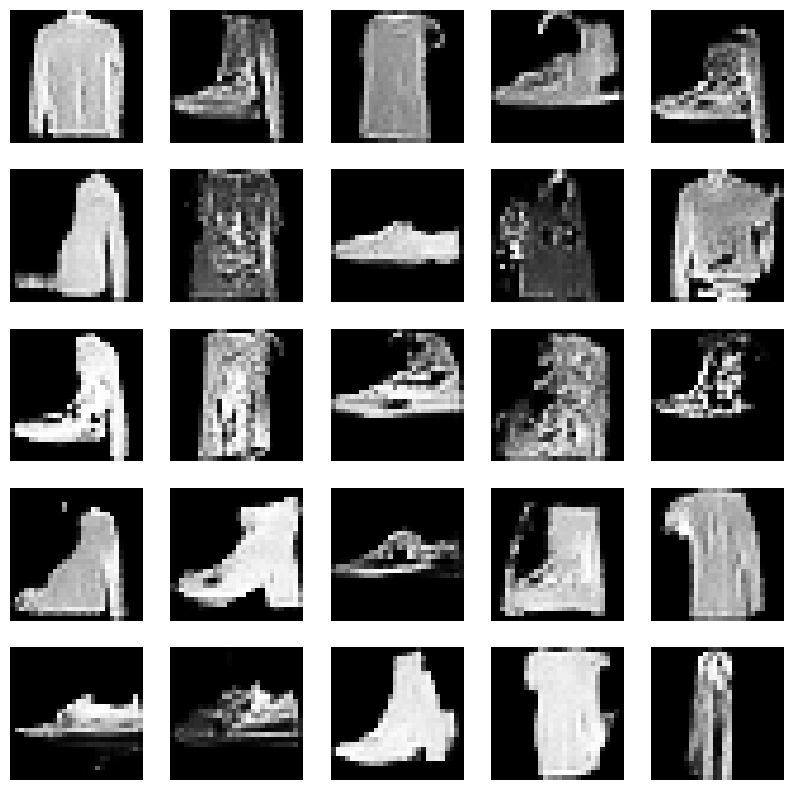

In [ ]:
plot_generated_images(generator, square=5)

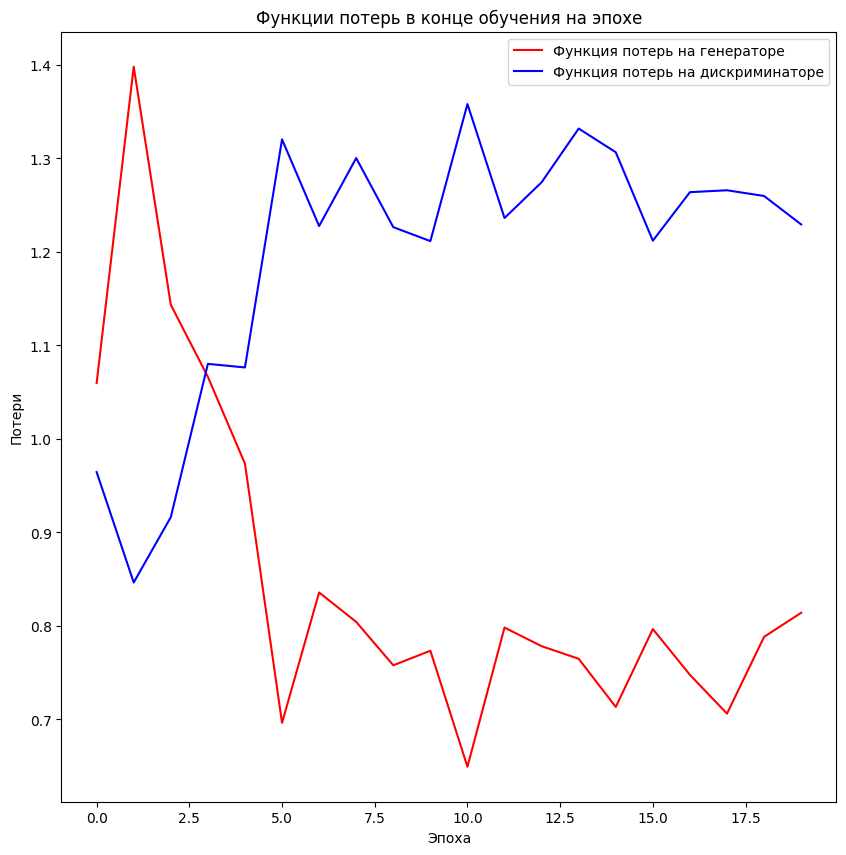

In [ ]:
def loss_plot(G, D):
    plt.figure(figsize=(10,10))
    plt.plot(G,color='red',label='Функция потерь на генераторе')
    plt.plot(D,color='blue',label='Функция потерь на дискриминаторе')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('Функции потерь в конце обучения на эпохе')
    plt.show()
loss_plot(G, D)